In [36]:
import pandas as pd
import os
os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"
import numpy as np
import re
import spacy
import networkx as nx
import matplotlib.pyplot as plt

# For huggingface pipelines / advanced modeling
from transformers import pipeline, AutoTokenizer, AutoModelForTokenClassification
from bertopic import BERTopic

# If you plan on using sentence-transformers for embeddings:
from sentence_transformers import SentenceTransformer

# Load your data
df = pd.read_pickle("eskimo_folktales.pkl")

print("Data loaded. Shape:", df.shape)
df.head()


Data loaded. Shape: (51, 3)


,story_id,title,text
0,1,"The Coming of Men, A Long, Long While Ago",Our forefathers have told us much of the comin...
1,2,"Nukúnguasik, Who Escaped from the Tupilak","Nukúnguasik, it is said, had land in a place w..."
2,3,Qujâvârssuk,A strong man had land at Ikerssuaq. The only o...
3,4,Kúnigseq,There was once a wizard whose name was Kúnigse...
4,5,The Woman Who Had a Bear As a Foster-Son,There was once an old woman living in a place ...


2.2 Exploratory Data Analysis (EDA)

In [37]:
print(df.info())

print(df.isnull().sum())
print("Duplicate story IDs:", df.story_id.duplicated().sum())

df["text_length"] = df["text"].apply(lambda x: len(x.split()))
df["text_length"].describe()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   story_id  51 non-null     int64 
 1   title     51 non-null     object
 2   text      51 non-null     object
dtypes: int64(1), object(2)
memory usage: 1.3+ KB
None
story_id    0
title       0
text        0
dtype: int64
Duplicate story IDs: 0


count      51.000000
mean      840.450980
std      1051.865701
min       106.000000
25%       453.000000
50%       599.000000
75%       888.500000
max      7521.000000
Name: text_length, dtype: float64

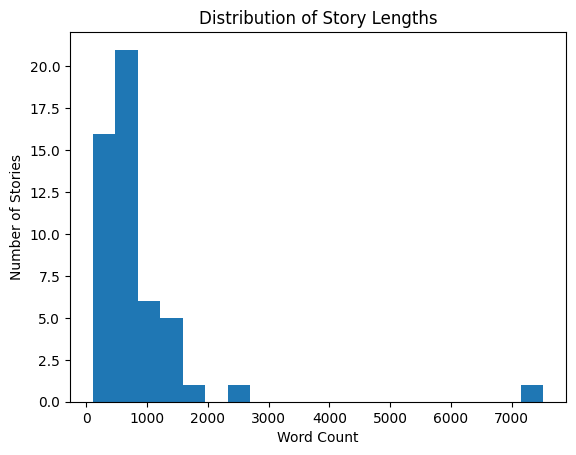

In [38]:
plt.hist(df["text_length"], bins=20)
plt.title("Distribution of Story Lengths")
plt.xlabel("Word Count")
plt.ylabel("Number of Stories")
plt.show()

More Concise Cleaning

In [39]:
import re

df["text"] = df["text"].str.replace(r"\n", " ", regex=True)


def clean_text_for_ner(text: str) -> str:
    """
    Cleans raw folklore text while preserving paragraph breaks.
    1. Unify all line endings to '\n'.
    2. Split into paragraphs on two or more newlines.
    3. Clean each paragraph by removing extra internal line breaks and spaces.
    4. Normalize curly quotes, dashes.
    5. Rejoin paragraphs with a single blank line.
    """

    # 1. Unify line endings
    text = text.replace("\r\n", "\n").replace("\r", "\n")

    # 2. Split on two or more newlines to preserve paragraph boundaries
    paragraphs = re.split(r'\n\s*\n+', text.strip())

    cleaned_paragraphs = []
    for para in paragraphs:
        # Remove stray newlines inside each paragraph
        para = re.sub(r'\n+', ' ', para)

        # Normalize curly quotes and dashes
        para = para.replace('’', "'").replace('‘', "'").replace('—', '-')

        # Reduce multiple spaces to a single space
        para = re.sub(r'\s+', ' ', para).strip()

        cleaned_paragraphs.append(para)

    # 5. Rejoin paragraphs with exactly one blank line (two newlines)
    cleaned_text = "\n\n".join(cleaned_paragraphs)
    return cleaned_text

# Apply the cleaning function
df["clean_text"] = df["text"].apply(clean_text_for_ner)

In [40]:
import nltk
nltk.download('punkt')
nltk.download('words')

from nltk.corpus import words

# Get a set of English vocabulary words (in lowercase)
english_vocab = set(w.lower() for w in words.words())

def contains_non_ascii(token):
    """Return True if the token contains any non-ASCII characters."""
    return any(ord(char) > 127 for char in token)

# Initialize a set to hold candidate tokens
candidate_tokens = set()

# Loop through each cleaned text in your folktales DataFrame
for text in df['clean_text']:
    tokens = nltk.word_tokenize(text)
    for token in tokens:
        # Filter out tokens that are not alphabetic (ignore punctuation, numbers)
        if not token.isalpha():
            continue
        
        # Heuristic 1: Check if token is capitalized and not a common English word.
        if token[0].isupper() and token.lower() not in english_vocab:
            candidate_tokens.add(token)
        
        # Heuristic 2: If token contains non-ASCII characters, add it as well.
        elif contains_non_ascii(token):
            candidate_tokens.add(token)

# Sort and display candidate tokens
sorted_candidates = sorted(candidate_tokens)
print("Candidate tokens (potential names/entities) not common in English:")
for token in sorted_candidates:
    print(token)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lukaskreibig/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/lukaskreibig/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


Candidate tokens (potential names/entities) not common in English:
Ailaq
Aluk
Alátaq
Amerdloq
Anarteq
Angiut
Angmagssalik
Angusinãnguaq
Artuk
Asalôq
Atakana
Atdlarneq
Atungait
Au
Avôvang
Ernilik
Etah
Eyes
Ghosts
Hahaha
Has
Having
Hrrrr
Hunters
Ikerssuaq
Isigâligârssik
Kangerdlugssuaq
Kangârssuk
Kilitêraq
Kumagdlak
Kánagssuaq
Kâgssagssuk
Kúnigseq
Kûgkat
Makíte
Misána
Natsivilik
Navaránâ
Navaránâpaluk
Navssârssuaq
Nerrivik
Neruvkâq
Nipisartángivaq
Nukúnguasik
Nâlaussartoq
Ones
Papik
Puagssuaq
Pualúna
Pâtussorssuaq
Qalagánguasê
Qasiagssaq
Qautaq
Qigdlugsuk
Qilugtûssat
Qujâvârssuk
Sarqiserasak
Saunikoq
Suagaq
Sârdloq
Talîlarssuaq
Tugto
Tungujuluk
Tupilak
Tupilaks
Tôrnârssuk
Ukaleq
Umerdlugtoq
Ángángŭjuk
Âtârssuaq
Íkardlítuarssuk
Ímarasugssuaq


In [41]:
# Convert candidate tokens to a DataFrame and save to CSV for review
candidate_df = pd.DataFrame(sorted_candidates, columns=["entity_candidate"])
candidate_df.to_csv("candidate_entities.csv", index=False)
print("Saved candidate entities to 'candidate_entities.csv'.")

Saved candidate entities to 'candidate_entities.csv'.


In [43]:
import pandas as pd

# Load your finished candidate entities CSV.
# It should have columns like "entity_candidate" and "entity"
candidates_df = pd.read_csv("candidate_entities_finished.csv")
print(candidates_df.head())

# Create a dictionary mapping token (lowercase) to its label.
# For example, both "tupilak" and "tupilaks" can be in your CSV.
entity_dict = dict(zip(candidates_df["entity_candidate"].str.lower(), candidates_df["entity"]))
print("Entity Dictionary:")
for key, val in entity_dict.items():
    print(f"{key}: {val}")


  entity_candidate entity
0            Ailaq    PER
1             Aluk    PER
2           Alátaq    PER
3         Amerdloq    PER
4          Anarteq    PER
Entity Dictionary:
ailaq: PER
aluk: PER
alátaq: PER
amerdloq: PER
anarteq: PER
angiut: SPI
angmagssalik: LOC
angusinãnguaq: PER
artuk: PER
asalôq: PER
atakana: PER
atdlarneq: PER
atungait: PER
au: O
avôvang: PER
ernilik: PER
etah: LOC
eyes: O
ghosts: O
hahaha: O 
has: O
having: O
hrrrr: O
hunters: O
ikerssuaq: LOC
isigâligârssik: PER
kangerdlugssuaq: LOC
kangârssuk: LOC
kilitêraq: PER
kumagdlak: PER
kánagssuaq: PER
kâgssagssuk: PER
kúnigseq: PER
kûgkat: PER
makíte: PER
misána: PER
natsivilik: LOC
navaránâ: PER
navaránâpaluk: PER
navssârssuaq: PER
nerrivik: SPI
neruvkâq: PER
nipisartángivaq: PER
nukúnguasik: PER
nâlaussartoq: SPI
ones: O
papik: PER
puagssuaq: PER
pualúna: PER
pâtussorssuaq: PER
qalagánguasê: SPI
qasiagssaq: PER
qautaq: PER
qigdlugsuk: PER
qilugtûssat: SPI
qujâvârssuk: PER
sarqiserasak: MON
saunikoq: PER
suagaq: PER
s

In [ ]:
# Use the "fast" tokenizer
tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER", use_fast=True)
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")

ner_pipeline = pipeline(
    "ner",
    model=model,
    tokenizer=tokenizer,
    aggregation_strategy="simple")

df["entities"] = df["clean_text"].apply(lambda x: ner_pipeline(x))
df["entities"].head()


In [ ]:
df.head(10)

In [ ]:
df['text'][1]

Entity Classification / Custom Labels

In [ ]:
# def classify_entity(entity_text: str) -> str:
#     # example rules
#     # in real production, you'd have a better approach or a fine-tuned model
#     mythical_keywords = ["spirit", "wizard", "shaman", "tupilak"]
#     animal_keywords   = ["bear", "dog", "wolf", "fox"]
#     # expand with more, or use synonyms

#     text_lower = entity_text.lower()
#     if any(k in text_lower for k in mythical_keywords):
#         return "SUPER_NATURAL"
#     elif any(k in text_lower for k in animal_keywords):
#         return "ANIMAL"
#     else:
#         return "UNKNOWN"

# def annotate_entities(entities):
#     annotated = []
#     for ent in entities:
#         ent_text = ent["word"]
#         # ent['entity_group'] might be 'PER', 'LOC', 'ORG', etc. from the HF model
#         label = classify_entity(ent_text)
#         # create new dict with custom label
#         annotated.append({
#             "text": ent_text,
#             "hf_label": ent["entity_group"],
#             "custom_label": label,
#             "score": ent["score"],
#         })
#     return annotated

# df["annotated_entities"] = df["entities"].apply(annotate_entities)


In [ ]:
df.head(10)

In [ ]:
def merge_subwords(token_entities, max_gap=1):
    """
    Merge adjacent subwords if all conditions match:
     - They share the same entity_group.
     - The next subword starts within 'max_gap' characters of the previous token's end
       OR the subword starts with '##'.
    """
    merged = []
    current = None

    for item in token_entities:
        w = item["word"]
        entity_group = item["entity_group"]
        start = item["start"]
        end = item["end"]

        if current is None:
            current = {**item}
            continue

        # Same entity group?
        same_group = (entity_group == current["entity_group"])

        # Subword indicator or near-adjacent offsets?
        subword_prefix = w.startswith("##")
        close_offsets = (start - current["end"]) <= max_gap

        if same_group and (subword_prefix or close_offsets):
            # Merge into current
            current["word"] += w.replace("##", "")
            current["end"] = end
            # Optional: keep the highest score
            current["score"] = max(current["score"], item["score"])
        else:
            # Different entity group or not adjacent => close off current
            merged.append(current)
            current = {**item}

    if current:
        merged.append(current)

    return merged

In [ ]:
df["merged_entities"] = df["entities"].apply(merge_subwords)
df.head(3)

In [ ]:
df_one = df["entities"][1]
len(df_one)

In [ ]:
df_one = df["merged_entities"][1]
print(len(df_one))
df_one

In [ ]:
import requests
from bs4 import BeautifulSoup

url = "https://en.wiktionary.org/wiki/Appendix:Greenlandic_given_names"
response = requests.get(url)
html = response.text

soup = BeautifulSoup(html, "html.parser")

# We expect names to appear inside <dd> or <a> elements within the main content area.
names = set()  # use a set to avoid duplicates

# Strategy 1: Grab all <dd> elements inside <dl> (the dictionary list) and parse them
all_dds = soup.select("dl dd")

for dd in all_dds:
    # (a) If there's a direct <a> link with a name
    links = dd.find_all("a")
    for link in links:
        # Link text is often the name, e.g. "Aaju" or "Amâsa"
        candidate_name = link.get_text(strip=True)
        if candidate_name:
            names.add(candidate_name)

    # (b) The dd might have text outside <a>, e.g. "Amasa* (<i>Amâsa</i>) m 11 1939-2007"
    # We can do a simple extraction of the entire text of <dd> to see if there's a name we missed:
    full_text = dd.get_text(" ", strip=True)
    # If you want to do more advanced parsing here, do it with regex or string splitting.
    # E.g., look for capital words near parentheses. For now, we’ll just demonstrate:
    # (If "Amasa" is outside the <a>, we might parse it.)
    # This approach can be more refined based on your exact HTML structure:
    # 
    # import re
    # pattern = re.compile(r"[A-Z][a-zA-Zûâåé]*(?=\s*\()")  # example
    # found = pattern.findall(full_text)
    # for f in found:
    #     names.add(f)

# Convert set to sorted list for consistency
sorted_names = sorted(names)
print("Extracted names:")
for nm in sorted_names:
    print(nm)


In [ ]:
len(sorted_names)

In [ ]:
import requests
from bs4 import BeautifulSoup

url = "https://en.wikipedia.org/wiki/List_of_cities_and_towns_in_Greenland"
response = requests.get(url)
soup = BeautifulSoup(response.text, "html.parser")

towns = set()

# Find ALL the tables with class="wikitable"
tables = soup.find_all("table", class_="wikitable")

# Loop through each table
for table in tables:
    # Each row might contain a <th> or <td> with a link to the town
    rows = table.find_all("tr")

    for row in rows:
        # Some rows have multiple <td>, or might store the link in <th>, so let's find all <a> in the row
        links = row.find_all("a", href=True)
        for link in links:
            name = link.get_text(strip=True)
            if not name or len(name) < 2:
                continue
            
            # Simple filter for generic or obviously non-town links
            # e.g., skip "edit", "Coordinates", "Articles", etc.
            if any(bad_word in name.lower() for bad_word in [
                "edit", "coordinate", "article", "statement", "isbn",
                "list of", "administrative", "autonomy",
                "history", "portal"
            ]):
                continue

            towns.add(name)

# Convert to sorted list for easy viewing
sorted_towns = sorted(towns)
print(f"Found {len(sorted_towns)} possible town names from all tables:")
for town in sorted_towns:
    print(town)


In [ ]:
####################################
# 1. SCRAPE GREENLANDIC NAMES/TOWNS
####################################
import requests
from bs4 import BeautifulSoup

# Scrape personal names from Wiktionary
url_names = "https://en.wiktionary.org/wiki/Appendix:Greenlandic_given_names"
resp_names = requests.get(url_names)
html_names = resp_names.text

soup_names = BeautifulSoup(html_names, "html.parser")

greenlandic_names = set()
all_dds = soup_names.select("dl dd")
for dd in all_dds:
    links = dd.find_all("a")
    for link in links:
        candidate = link.get_text(strip=True)
        if candidate:
            greenlandic_names.add(candidate)

    full_text = dd.get_text(" ", strip=True)
    # If you want deeper parsing with regex, you can do so here

greenlandic_names = {nm for nm in greenlandic_names if len(nm) > 1}
print(f"Collected {len(greenlandic_names)} possible Greenlandic personal names.")


# Scrape town/city names from Wikipedia
url_towns = "https://en.wikipedia.org/wiki/List_of_cities_and_towns_in_Greenland"
resp_towns = requests.get(url_towns)
html_towns = resp_towns.text

soup_towns = BeautifulSoup(html_towns, "html.parser")
town_tables = soup_towns.find_all("table", class_="wikitable")

greenlandic_towns = set()
for table in town_tables:
    rows = table.find_all("tr")
    for row in rows:
        links = row.find_all("a", href=True)
        for link in links:
            candidate = link.get_text(strip=True)
            if not candidate or len(candidate) < 2:
                continue
            # Filter out typical wiki noise
            if any(bad_word in candidate.lower() for bad_word in [
                "edit", "coordinate", "article", "statement", "isbn",
                "list of", "administrative", "autonomy", "history", "portal"
            ]):
                continue
            greenlandic_towns.add(candidate)

print(f"Collected {len(greenlandic_towns)} possible Greenlandic town/city names.")


############################
# 2. LOAD & CLEAN FOLKTALES
############################
import pandas as pd
import re

df = pd.read_pickle("eskimo_folktales.pkl")  # your original data
print("Data loaded. Shape:", df.shape)

# Basic cleaning: remove stray newlines, unify line endings, etc.
df["text"] = df["text"].str.replace(r"\r\n|\n|\r", " ", regex=True)

def clean_text_for_ner(text: str) -> str:
    # Normalize quotes/dashes
    text = text.replace('’', "'").replace('‘', "'").replace('—', '-')
    # Remove extra spaces
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["clean_text"] = df["text"].apply(clean_text_for_ner)
print(df.head(3))


###################################
# 3. AUTOMATIC NER LABEL GENERATION
###################################
# We'll create a quick method that:
#  - Splits text into sentences (very basic approach)
#  - Splits each sentence into tokens
#  - Checks if token is in the personal name or town set
#  - Assigns "PER" or "LOC" if matched, else "O"
#
# Note: This is a naive approach but a good starting point for building
# a "silver" dataset you can refine manually.

import nltk
nltk.download("punkt")  # Ensure you have the NLTK tokenizer data

def auto_label_greenlandic(text, person_names, town_names):
    """
    Splits text into sentences and tokens, then assigns NER tags based on dictionary lookups.
    B- / I- tagging is optional if you want strict BIO formatting. We'll keep it simple: PER, LOC, or O.
    """
    sentences = nltk.sent_tokenize(text)

    data_rows = []
    for sent_id, sentence in enumerate(sentences):
        tokens = nltk.word_tokenize(sentence)
        for token_id, token in enumerate(tokens):
            # default is O
            ner_label = "O"
            # check dictionary matches (case-insensitive)
            token_lower = token.lower()

            # If EXACT match is too strict, consider substring or partial match
            # (But exact is simpler for this demonstration)
            if token in person_names:
                ner_label = "PER"
            elif token in town_names:
                ner_label = "LOC"

            # Alternatively, do case-insensitive match:
            # if token_lower in {n.lower() for n in person_names}:
            #     ner_label = "PER"
            # elif token_lower in {t.lower() for t in town_names}:
            #     ner_label = "LOC"

            data_rows.append({
                "sentence_id": sent_id,
                "token": token,
                "ner_label": ner_label
            })

    return data_rows

# We'll do this for each row in df and accumulate results
all_rows = []
doc_id = 0
for idx, row in df.iterrows():
    text = row["clean_text"]
    # auto-label
    labeled_tokens = auto_label_greenlandic(text, greenlandic_names, greenlandic_towns)
    for item in labeled_tokens:
        # add the doc id so we can separate by text
        all_rows.append({
            "doc_id": doc_id,
            "sentence_id": item["sentence_id"],
            "token": item["token"],
            "ner_label": item["ner_label"]
        })
    doc_id += 1

# Create a DataFrame
auto_ner_df = pd.DataFrame(all_rows)
print("Auto-labeled DataFrame size:", auto_ner_df.shape)
auto_ner_df.head(20)

# We can now save this in a typical "CoNLL-style" CSV or TSV for manual refinement
auto_ner_df.to_csv("auto_ner_data.csv", index=False)

print("Saved auto-labeled NER data to 'auto_ner_data.csv'.")


In [ ]:
def label_token(token, prev_label, name_set, town_set):
    # default
    label = "O"

    if token in name_set:
        label = "B-PER" if prev_label != "PER" else "I-PER"
    elif token in town_set:
        label = "B-LOC" if prev_label != "LOC" else "I-LOC"

    return label

# ... then for each token, check if the last label was PER or LOC, etc.


In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
nltk.download("punkt")

import requests
from bs4 import BeautifulSoup
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer, pipeline
import evaluate
import matplotlib.pyplot as plt


In [ ]:
########################
# Scrape personal names
########################
url_names = "https://en.wiktionary.org/wiki/Appendix:Greenlandic_given_names"
resp_names = requests.get(url_names)
soup_names = BeautifulSoup(resp_names.text, "html.parser")

greenlandic_names = set()
for dd in soup_names.select("dl dd"):
    # gather names in <a>
    for link in dd.find_all("a"):
        candidate = link.get_text(strip=True)
        if len(candidate) > 1:
            greenlandic_names.add(candidate)

    # optionally parse text outside <a>
    # ...
print(f"Collected {len(greenlandic_names)} possible Greenlandic personal names.")


###########################
# Scrape town/city names
###########################
url_towns = "https://en.wikipedia.org/wiki/List_of_cities_and_towns_in_Greenland"
resp_towns = requests.get(url_towns)
soup_towns = BeautifulSoup(resp_towns.text, "html.parser")

greenlandic_towns = set()
tables = soup_towns.find_all("table", class_="wikitable")
for table in tables:
    rows = table.find_all("tr")
    for row in rows:
        links = row.find_all("a", href=True)
        for link in links:
            candidate = link.get_text(strip=True)
            # skip short, empty, or wiki nav links
            if len(candidate) < 2:
                continue
            if any(bad in candidate.lower() for bad in [
                "edit", "coordinate", "article", "statement", "isbn",
                "list of", "administrative", "autonomy", "history", "portal"
            ]):
                continue
            greenlandic_towns.add(candidate)

print(f"Collected {len(greenlandic_towns)} possible Greenlandic town/city names.")


In [ ]:
df = pd.read_pickle("eskimo_folktales.pkl")
print("Data loaded. Shape:", df.shape)

# Simple cleaning
df["text"] = df["text"].str.replace(r"\r\n|\n|\r", " ", regex=True)
def clean_text_for_ner(text: str) -> str:
    text = text.replace('’', "'").replace('‘', "'").replace('—', '-')
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["clean_text"] = df["text"].apply(clean_text_for_ner)
print(df.head(3))


In [ ]:
print("Sample Greenlandic Names:", list(greenlandic_names)[:10])
print("Sample Greenlandic Towns:", list(greenlandic_towns)[:10])

In [ ]:
def auto_label_greenlandic(text, person_names, town_names):
    sentences = nltk.sent_tokenize(text)
    data_rows = []

    # Convert dictionaries to lowercase for matching
    person_names_lower = {name.lower() for name in person_names}
    town_names_lower = {name.lower() for name in town_names}

    for sent_id, sentence in enumerate(sentences):
        tokens = nltk.word_tokenize(sentence)
        for token in tokens:
            ner_label = "O"
            # Use lowercase for matching
            token_lower = token.lower()
            if token_lower in person_names_lower:
                ner_label = "PER"
            elif token_lower in town_names_lower:
                ner_label = "LOC"
            data_rows.append({
                "sentence_id": sent_id,
                "token": token,
                "ner_label": ner_label
            })
    return data_rows


all_rows = []
doc_id = 0
for idx, row in df.iterrows():
    labeled_tokens = auto_label_greenlandic(row["clean_text"], greenlandic_names, greenlandic_towns)
    for item in labeled_tokens:
        all_rows.append({
            "doc_id": doc_id,
            "sentence_id": item["sentence_id"],
            "token": item["token"],
            "ner_label": item["ner_label"]
        })
    doc_id += 1

auto_ner_df = pd.DataFrame(all_rows)
print("Auto-labeled DataFrame size:", auto_ner_df.shape)
auto_ner_df.head(20)


In [ ]:
# For document 0, sentence 0:
doc0_sent0 = auto_ner_df[(auto_ner_df['doc_id'] == 0) & (auto_ner_df['sentence_id'] == 0)]
print(doc0_sent0)


In [ ]:
grouped = auto_ner_df.groupby(["doc_id", "sentence_id"])

examples = []
for (doc_id, sent_id), group in grouped:
    tokens = group["token"].tolist()
    labels = group["ner_label"].tolist()
    examples.append({
        "doc_id": doc_id,
        "sentence_id": sent_id,
        "tokens": tokens,
        "ner_tags": labels
    })

df_grouped = pd.DataFrame(examples)
print("Grouped DataFrame shape:", df_grouped.shape)
df_grouped.head()


In [ ]:
train_size = int(0.8 * len(df_grouped))
train_df = df_grouped.iloc[:train_size]
val_df = df_grouped.iloc[train_size:]

print("Train size:", train_df.shape)
print("Val size:", val_df.shape)


In [ ]:
from datasets import Dataset, DatasetDict

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

raw_datasets = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset
})
raw_datasets

In [ ]:
label_list = ["O", "PER", "LOC"]
label2id = {lbl: i for i, lbl in enumerate(label_list)}
id2label = {i: lbl for lbl, i in label2id.items()}

from transformers import AutoTokenizer

model_checkpoint = "xlm-roberta-base"  # better for non-English
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)


In [ ]:
def tokenize_and_align_labels(examples):
    # Tokenize the list-of-tokens for each example.
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        max_length=256
    )
    
    all_labels = []
    # Loop over each example in the batch
    for i in range(len(examples["tokens"])):
        # Get the mapping from subword to word index for this example
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        example_labels = examples["ner_tags"][i]
        aligned_labels = []
        # For each token produced by the tokenizer, assign a label
        for word_id in word_ids:
            if word_id is None:
                # Special tokens like [CLS], [SEP], or padding
                aligned_labels.append(-100)
            else:
                aligned_labels.append(label2id[example_labels[word_id]])
        all_labels.append(aligned_labels)
    
    tokenized_inputs["labels"] = all_labels
    return tokenized_inputs

processed_datasets = raw_datasets.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=raw_datasets["train"].column_names
)


In [ ]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        max_length=256
    )
    
    all_labels = []
    # Process each example in the batch individually
    for i in range(len(examples["tokens"])):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        example_labels = examples["ner_tags"][i]
        aligned_labels = []
        for word_id in word_ids:
            if word_id is None:
                aligned_labels.append(-100)
            else:
                aligned_labels.append(label2id[example_labels[word_id]])
        all_labels.append(aligned_labels)
    
    tokenized_inputs["labels"] = all_labels
    return tokenized_inputs

processed_datasets = raw_datasets.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=raw_datasets["train"].column_names
)


In [ ]:
auto_ner_df.head(20)

In [ ]:
auto_ner_df['ner_label'].value_counts()

In [ ]:
grouped_sentences = auto_ner_df.groupby(['doc_id', 'sentence_id'])['token'].apply(list)
grouped_labels = auto_ner_df.groupby(['doc_id', 'sentence_id'])['ner_label'].apply(list)

grouped_sentences.head(10)

In [ ]:
grouped_labels.head(10)

In [ ]:
# import numpy as np
# import evaluate

# seqeval = evaluate.load("seqeval")

# def compute_metrics(p):
#     predictions, labels = p
#     # Get predicted label indices (take the argmax over the last dimension)
#     predictions = np.argmax(predictions, axis=2)

#     true_labels = []
#     true_preds = []
    
#     # Iterate over each example in the batch
#     for pred_row, label_row in zip(predictions, labels):
#         temp_true_labels = []
#         temp_true_preds = []
#         for p_i, l_i in zip(pred_row, label_row):
#             # Skip special tokens that are marked as -100
#             if l_i == -100:
#                 continue
#             temp_true_labels.append(id2label[l_i])
#             temp_true_preds.append(id2label[p_i])
#         # Only add examples that have at least one valid token
#         if temp_true_labels:
#             true_labels.append(temp_true_labels)
#             true_preds.append(temp_true_preds)
    
#     # If no valid tokens exist, return default values
#     if len(true_labels) == 0:
#         return {"precision": 0.0, "recall": 0.0, "f1": 0.0, "accuracy": 1.0}
    
#     results = seqeval.compute(predictions=true_preds, references=true_labels)
#     return {
#         "precision": results.get("overall_precision", 0.0),
#         "recall": results.get("overall_recall", 0.0),
#         "f1": results.get("overall_f1", 0.0),
#         "accuracy": results.get("overall_accuracy", 1.0)
#     }


# from transformers import DataCollatorForTokenClassification

# data_collator = DataCollatorForTokenClassification(tokenizer, padding=True)

# num_labels = len(label_list)
# model = AutoModelForTokenClassification.from_pretrained(
#     model_checkpoint,
#     num_labels=num_labels,
#     id2label=id2label,
#     label2id=label2id
# )

# training_args = TrainingArguments(
#     output_dir="greenlandic_ner_checkpoints",
#     evaluation_strategy="epoch",
#     save_strategy="epoch",
#     learning_rate=2e-5,
#     num_train_epochs=3,
#     weight_decay=0.01,
#     per_device_train_batch_size=4,
#     per_device_eval_batch_size=4,
#     logging_steps=50
# )


# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=processed_datasets["train"],
#     eval_dataset=processed_datasets["validation"],
#     tokenizer=tokenizer,
#     data_collator=data_collator,  # Add this line
#     compute_metrics=compute_metrics
# )

# trainer.train()


In [ ]:
# trainer.save_model("greenlandic_ner_model")
# tokenizer.save_pretrained("greenlandic_ner_model")

# ner_infer = pipeline(
#     "ner",
#     model="greenlandic_ner_model",
#     tokenizer="greenlandic_ner_model",
#     aggregation_strategy="simple"
# )

# test_text = "Nukúnguasik traveled from Ikerssuaq to Nuuk."
# print(ner_infer(test_text))
